In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import torch
from torch_geometric.data import Data
import gymnasium as gym
from gymnasium import spaces
from helpers_functions import *
from gerry_environment import FrankenmanderingEnv
from graph_initiator import build_init_data
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
def labels_to_action(labels, num_districts, dtype=np.float32):
    """
    Convert an integer label vector (shape [N]) to an action matrix
    expected by env.step: shape (N, num_districts), each row is
    a 1-hot encoding of the desired district for that voter.
    """
    N = len(labels)
    A = np.zeros((N, num_districts), dtype=dtype)
    for i, lab in enumerate(labels):
        if lab >= 0 and lab < num_districts:
            A[i, int(lab)] = 1.0
        else:
            # keep row zeros -> will become -1 label in env.step (avoid if possible)
            pass
    return A

In [4]:
def natural_OD(env, districts, num_districts, drf,geo_edge, Beta1,Beta2):
    assignment = labels_to_action(districts, num_districts)

    obs, reward, terminated, truncated, info = env.step(assignment,drf)
    opinions = np.array(obs.get_x())  # don't squeeze or convert to list
    target = np.array(env.get_target())

    dist_target = np.linalg.norm(opinions - target, axis=1).sum()
    #

    # print(f"opinions={opinions}, reward={reward} , distance to target opinion = {dist_target}")

    return obs, reward, dist_target

Inchworm with empty social graph

In [5]:



# random_tensors = [torch.randint(0, 6, (n,)) for _ in range(8)]
# districts = torch.tensor(dist_lbl)
# districts = [districts] + random_tensors

In [6]:
# init_data.get_geo_edge()

In [7]:
init_data, G_graph = build_init_data()
num_voters = init_data.get_x().shape[0]
dist_label = np.arange(num_voters)

target_opinion =  [7] * num_voters
num_districts = num_voters

env = FrankenmanderingEnv(num_voters=num_voters,
                          num_districts=num_voters,
                          opinion_dim=1,
                          init_FrankenData=init_data,
                          target_opinion=target_opinion)
history = []
obs, _ = env.reset()
for i in range(100):

  obs, reward, dist_target = natural_OD(env, dist_label, num_districts, drf_f1, init_data.get_geo_edge(), 0.1,0.5)

  history.append({
            "step": i,
            'obs': obs,
            'reward':reward,
            'dis_to_target': dist_target
        })

df_history = pd.DataFrame(history)
df_history.to_csv('df_history.csv')


BA (undirected) edges: 140 (expected m*(N-m) = 2*(72-2) = 140)
SOC directed arcs: 280 (should be 2 * 140 = 280)


**Reward Trajectory**

In [8]:
df_history.head()

,step,obs,reward,dis_to_target
0,0,"[(x, [tensor([6.4566]), tensor([4.2774]), tens...",23.517681,2150.667545
1,1,"[(x, [tensor([6.4405]), tensor([4.1160]), tens...",34.759480,2147.081751
2,2,"[(x, [tensor([6.4373]), tensor([3.9868]), tens...",39.313004,2151.442841
3,3,"[(x, [tensor([6.3819]), tensor([3.9058]), tens...",42.883350,2155.194389
4,4,"[(x, [tensor([6.3187]), tensor([3.8731]), tens...",45.728439,2160.961508


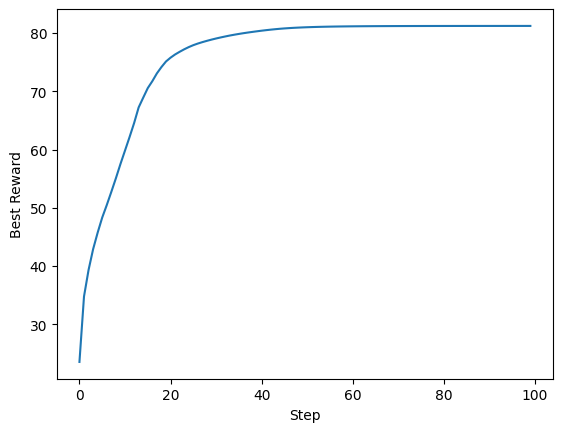

In [9]:
reward = df_history['reward']
plt.plot(range(len(reward)), reward)
plt.xlabel("Step")
plt.ylabel("Best Reward")
plt.show()

In [10]:
# line plot
res_mean = df_history['dis_to_target'].mean()
res_std = df_history['dis_to_target'].std()
print('res_mean = ',res_mean)
print('res_std=', res_std)

res_mean =  2084.620600823269
res_std= 24.250665264337492


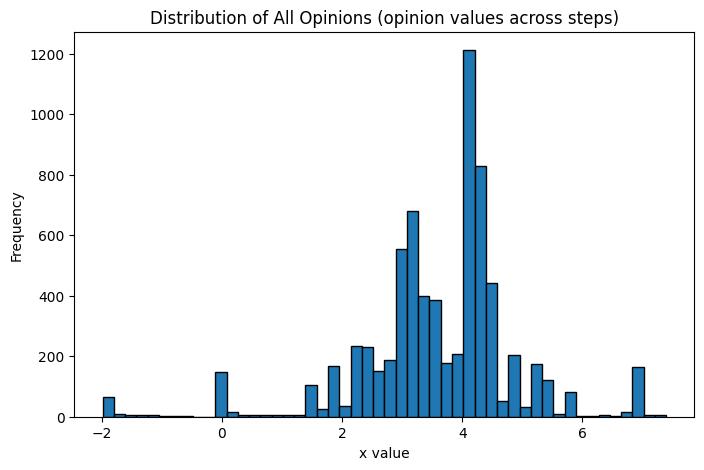

In [11]:
def opinion_distribution(df,all_x):
  # best_model = df['best_model_stage']
  all_opinion = []

  # for row in best_model:
  #   all_opinion.append(row.get_x())

  all_opinion_tensor = torch.cat(all_x)
  all_opinion_np = all_opinion_tensor.cpu().numpy()

  return all_opinion_np, all_opinion

# plot
# best_model = df_summary['best_model_stage']
all_x = [data.x for data in df_history['obs']]
all_opinion_np, all_opinion = opinion_distribution(df_history, all_x)

plt.figure(figsize=(8,5))
plt.hist(all_opinion_np, bins=50, edgecolor='black')
plt.title("Distribution of All Opinions (opinion values across steps)")
plt.xlabel("x value")
plt.ylabel("Frequency")
plt.show()

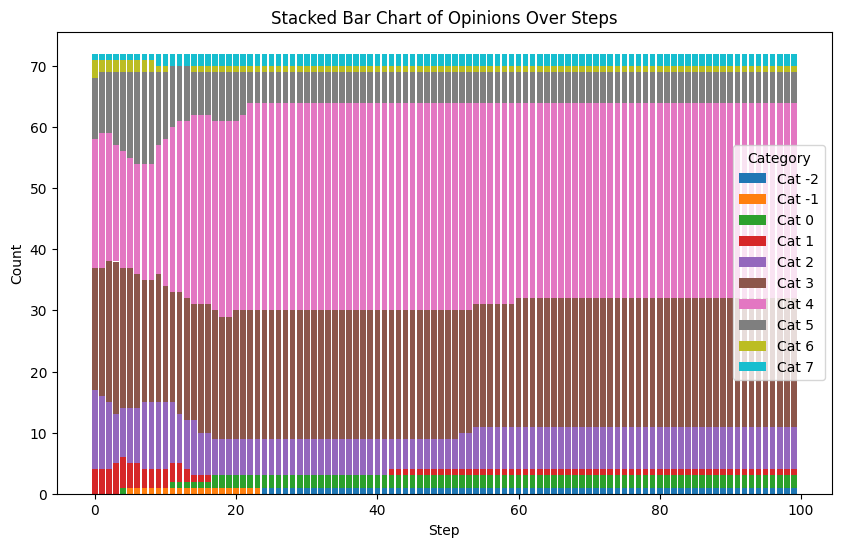

Category -2: 76.0 occurrences
Category -1: 19.0 occurrences
Category 0: 173.0 occurrences
Category 1: 111.0 occurrences
Category 2: 697.0 occurrences
Category 3: 2089.0 occurrences
Category 4: 3122.0 occurrences
Category 5: 615.0 occurrences
Category 6: 107.0 occurrences
Category 7: 191.0 occurrences


In [12]:
# frequency of different opinions in each outer step
def opnion_freq(all_opinion,num_steps):

  all_opinion_np = [op.cpu().numpy() if isinstance(op, torch.Tensor) else np.array(op) for op in all_opinion]
  all_opinion_np = np.round(all_opinion_np)

  # num_steps = len(all_opinion_np)
  categories, _ = np.unique(all_opinion_np, return_counts=True)

  counts = np.zeros((num_steps,len(categories)))

  for i, opinions in enumerate(all_opinion_np):
      for j, cat in enumerate(categories):
        counts[i, j] = np.sum(opinions == cat)

  return  categories, counts

# Plot
num_steps = len(all_x)
categories, counts = opnion_freq(all_x,num_steps)
x = np.arange(num_steps)
bottom = np.zeros(num_steps)

plt.figure(figsize=(10, 6))

for j, cat in enumerate(categories):
    plt.bar(x, counts[:, j], bottom=bottom, label=f'Cat {int(cat)}')
    bottom += counts[:, j]

plt.xlabel('Step')
plt.ylabel('Count')
plt.title('Stacked Bar Chart of Opinions Over Steps')
plt.legend(title='Category')
plt.show()

# Overall frequency of each category across all steps
total_frequency = counts.sum(axis=0)
for cat, freq in zip(categories, total_frequency):
    print(f'Category {int(cat)}: {freq} occurrences')


In [13]:
# init_data.edge_index

In [14]:
# init_data.get_x()